2/2 [==============================] - 0s 5ms/step
RMSE: 80681802.02131462
MAE: 36071276.1147475
2/2 [==============================] - 0s 1ms/step
RMSE: 78230931.77714083
MAE: 40559447.324444465
2/2 [==============================] - 0s 1ms/step
RMSE: 80220384.77522767
MAE: 36080927.72848488
2/2 [==============================] - 0s 1ms/step
RMSE: 74410417.49223858
MAE: 37094306.650505066
2/2 [==============================] - 0s 1ms/step
RMSE: 79783534.43845865
MAE: 40411122.812121235
2/2 [==============================] - 0s 1ms/step
RMSE: 72044471.07650305
MAE: 39784198.10262628
2/2 [==============================] - 0s 1ms/step
RMSE: 72444458.22251466
MAE: 42340947.67838385
2/2 [==============================] - 0s 1ms/step
RMSE: 67328102.91980845
MAE: 55151699.70424244
2/2 [==============================] - 0s 1ms/step
RMSE: 75233920.50611097
MAE: 40319575.16929295
2/2 [==============================] - 0s 1ms/step
RMSE: 71912287.37554517
MAE: 39803862.109090924
2/2 [============

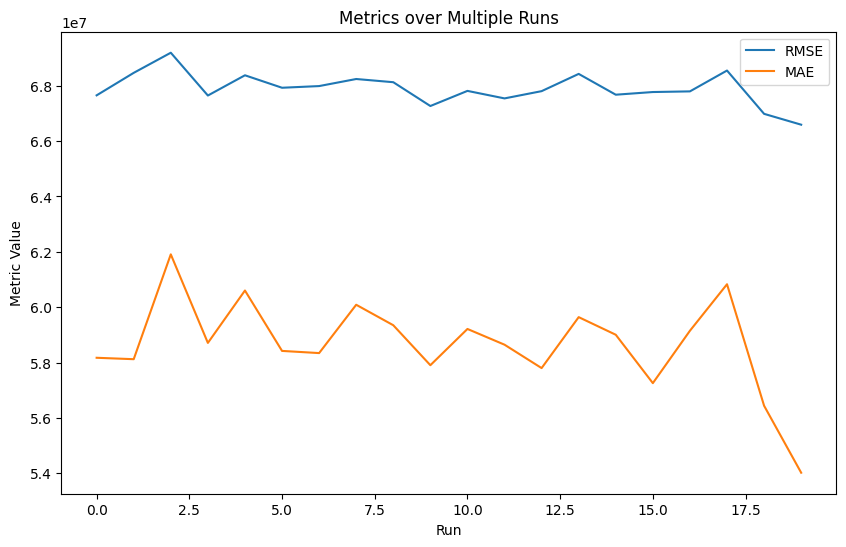

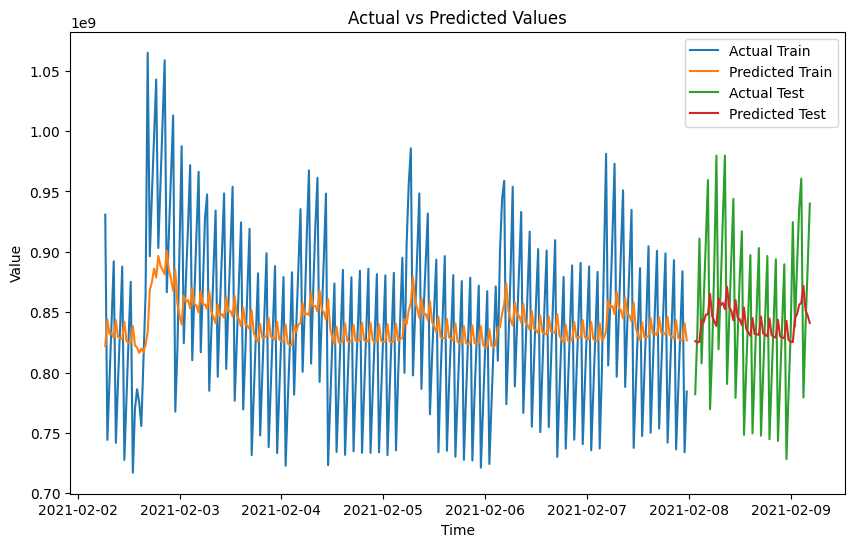

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

class MantaRay:
    def __init__(self, dim, lb, ub):
        self.position = np.random.uniform(lb, ub, dim)
        self.fitness = np.inf  # Initialize fitness to infinity

def MRFO(n, dim, n_iter, lb, ub, obj_func, n_steps):
    population = [MantaRay(dim, lb, ub) for _ in range(n)]
    best_manta = min(population, key=lambda x: x.fitness)

    for _ in range(n_iter):
        for manta in population:
            if np.random.rand() < 0.5:  # Spiral movement
                r = np.random.rand(dim)
                manta.position = best_manta.position + r * np.sin(2 * np.pi * r) * abs(best_manta.position - manta.position)
            else:  # Cyclic movement
                manta.position = best_manta.position + np.random.uniform(-1, 1, dim)

            manta.position = np.clip(manta.position, lb, ub)
            manta.fitness = obj_func(manta.position, n_steps)

            if manta.fitness < best_manta.fitness:
                best_manta = manta

    return best_manta.position, best_manta.fitness

# Define your objective function here
def obj_func(x, n_steps):
    n_units = int(x[0])
    n_epochs = int(x[1])
    n_features = 1

    # Define the RNN model architecture
    model = Sequential()
    model.add(Reshape((n_steps, n_features), input_shape=(n_steps,)))
    model.add(LSTM(n_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')

    # Train the model
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

    # Make predictions on the train and test sets
    train_pred = model.predict(X_train)
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)

    # Evaluate the model on the test set - RMSE
    rmse = np.sqrt(np.mean((test_pred - test.values)**2))
    print("RMSE:", rmse)

    #Evaluate the model on the test set - MAE
    mae = mean_absolute_error(test.values[n_steps:], test_pred)
    print("MAE:", mae)

    return rmse

metric_df = pd.read_pickle("../data/ts.pkl")

# Resample the data to 30-minute intervals
ts = metric_df["value"].astype(float).resample("30min").mean()

# Split the data into train and test sets
train = ts[:"2021-02-07"]
test = ts["2021-02-08":]

# Scale the data using a MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Define the number of time steps and features
n_steps = 3
n_features = 1

X_train, y_train = [], []
for i in range(n_steps, len(train_scaled)):
    X_train.append(train_scaled[i-n_steps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to be 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Create sequences of input data and target values for test set
X_test, y_test = [], []
for i in range(n_steps, len(test_scaled)):
    X_test.append(test_scaled[i-n_steps:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Parameters
n = 30  # Population size
dim = 2  # Dimension of the search space
n_iter = 10  # Number of iterations
lb = np.array([10, 1])  # Lower bound of the search space
ub = np.array([100, 100])  # Upper bound of the search space

# Run MRFO
best_position, best_fitness = MRFO(n, dim, n_iter, lb, ub, obj_func, n_steps)

# Extract the best hyperparameters
n_units, n_epochs = map(int, best_position)

# Train the model with the best hyperparameters
def train_and_evaluate_model(n_units, n_epochs, X_train, y_train, X_test, y_test, scaler):
    # Define the RNN model architecture
    model = Sequential()
    model.add(Reshape((n_steps, n_features), input_shape=(n_steps,)))
    model.add(LSTM(n_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')

    # Train the model
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

    # Make predictions on the train and test sets
    train_pred = model.predict(X_train)
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)

    # Evaluate the model on the test set - RMSE
    rmse = np.sqrt(np.mean((test_pred - test.values[n_steps:]) ** 2))

    # Evaluate the model on the test set - MAE
    mae = mean_absolute_error(test.values[n_steps:], test_pred)
    
    return rmse, mae, train_pred, test_pred


# Parameters for multiple runs
num_runs = 20  # Number of times to train the model

# Run MRFO
best_position, best_fitness = MRFO(n, dim, n_iter, lb, ub, obj_func, n_steps)

# Extract the best hyperparameters
n_units, n_epochs = map(int, best_position)

# Lists to store metrics
rmse_list = []
mae_list = []
train_preds_list = []
test_preds_list = []

# Train the model multiple times and collect metrics
for i in range(num_runs):
    rmse, mae, train_preds, test_preds = train_and_evaluate_model(n_units, n_epochs, X_train, y_train, X_test, y_test, scaler)
    rmse_list.append(rmse)
    mae_list.append(mae)
    train_preds_list.append(train_preds)
    test_preds_list.append(test_preds)
    
# Calculate mean metrics
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

print("Média de execuções RMSE over {} runs: {}".format(num_runs, mean_rmse))
print("Mean MAE over {} runs: {}".format(num_runs, mean_mae))

# Plot the metrics for each run
plt.figure(figsize=(10, 6))
plt.plot(rmse_list, label="RMSE")
plt.plot(mae_list, label="MAE")
plt.xlabel("Run")
plt.ylabel("Metric Value")
plt.legend()
plt.title("Metrics over Multiple Runs")
plt.show()

# Plot the actual vs predicted values for the train and test sets
plt.figure(figsize=(10, 6))
plt.plot(train.index[n_steps:], train.values[n_steps:], label="Actual Train")
plt.plot(train.index[n_steps:], train_preds_list[0], label="Predicted Train")
plt.plot(test.index[n_steps:], test.values[n_steps:], label="Actual Test")
plt.plot(test.index[n_steps:], test_preds_list[0], label="Predicted Test")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs Predicted Values")
plt.show()